In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.linalg import lstsq



Лінійне інтерполювання <br>
Поліноміальне інтерполювання <br>
Інтерполювання з використанням розкладу в ряд Фур’є <br>
Інтерполювання з використанням методу найменших квадратів. <br>

In [2]:
def image_change_scale(img, dimension, scale=100, interpolation=cv2.INTER_LINEAR):
    scale /= 100
    new_dimension = (int(dimension[1]*scale), int(dimension[0]*scale))
    resized_img = cv2.resize(img, new_dimension, interpolation=interpolation)

    return resized_img


In [3]:
doggy = cv2.imread("doggy.jpg")
doggy = cv2.cvtColor(doggy, cv2.COLOR_BGR2RGB)

### Лінійне інтерполювання

In [23]:
def bilinear_interpolation(image, resized_shape):
    height = image.shape[0]
    width = image.shape[1]

    scale_x = width / resized_shape[1]
    scale_y = height / resized_shape[0]

    new_image = np.zeros((resized_shape[0], resized_shape[1], image.shape[2]))

    for k in range(resized_shape[2]):
        for i in range(resized_shape[0]):
            for j in range(resized_shape[1]):

                x = (j + 0.5) * scale_x - 0.5
                y = (i + 0.5) * scale_y - 0.5

                x_int = min(int(x), width - 2)
                y_int = min(int(y), height - 2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = image[y_int, x_int, k]
                b = image[y_int, x_int + 1, k]
                c = image[y_int + 1, x_int, k]
                d = image[y_int + 1, x_int + 1, k]

                pixel = a * (1 - x_diff) * (1 - y_diff) + b * x_diff * (1 - y_diff) + c * (1 - x_diff) * y_diff + d * x_diff * y_diff

                new_image[i, j, k] = pixel.astype(np.uint8)

    return new_image.astype(np.uint8)


In [24]:
bilin_doggy = bilinear_interpolation(doggy, (600, 500, 3))

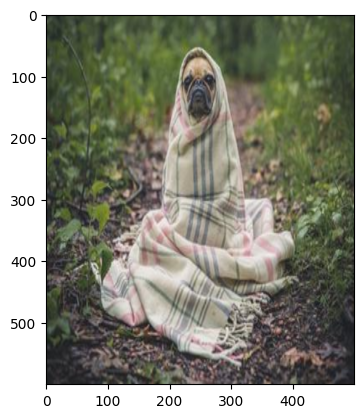

In [25]:
plt.imshow(bilin_doggy)

### Інтерполювання з використанням методу найменших квадратів

In [7]:
def get_coef_for_fxy(x: np.ndarray, y:np.ndarray, z: np.ndarray) -> np.ndarray:
    A = np.ones((x.shape[0], 3))
    A[..., 0] = x
    A[..., 1] = y
    B = np.dot(np.transpose(A), A)
    z_upd = np.dot(np.transpose(A), z)
    return np.dot(np.linalg.inv(B), z_upd)


In [43]:
def least_squares_interpolation(img, new_size):
    old_height, old_width, channels = img.shape
    new_height, new_width = new_size
    
    # Generate meshgrid for new coordinates
    new_y, new_x = np.meshgrid(np.linspace(0, old_height - 1, new_height), 
                               np.linspace(0, old_width - 1, new_width), indexing='ij')

    # Flatten the image
    image_flat = img.reshape(old_height * old_width, channels)

    # Construct the matrix A for least squares
    A = np.column_stack([np.ones(old_height * old_width), 
                         np.repeat(np.arange(old_height), old_width), 
                         np.tile(np.arange(old_width), old_height)])

    # Perform least squares separately for each channel
    interpolated_channels = []
    for channel in range(channels):
        coeffs, _, _, _ = np.linalg.lstsq(A, image_flat[:, channel], rcond=None)
        
        # Construct new coordinates
        new_coords = np.column_stack([np.ones(new_height * new_width), 
                                      new_y.flatten(), 
                                      new_x.flatten()])
        
        # Interpolate the channel
        interpolated_channel_flat = np.dot(new_coords, coeffs)
        interpolated_channel = interpolated_channel_flat.reshape(new_height, new_width)
        interpolated_channels.append(interpolated_channel)
    
    # Stack the interpolated channels to form the final RGB image
    interpolated_image = np.stack(interpolated_channels, axis=-1)
    
    return interpolated_image.astype(np.uint8)  # Convert to uint8 for proper image format




In [44]:
ls_doggy = least_squares_interpolation(doggy, (400, 300))

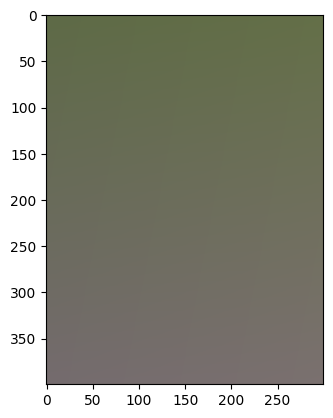

In [45]:
plt.imshow(ls_doggy)